#Atividade 6 Robert william da Silva
###Esta atividade tem como objetivo calcular uma série sintetica que representa a afluencia de uma determinada usina do SIN. Para isso um problema de otimização é resolvido para calcular os coeficientes da série sintetica. Neste trabalho o número otimo de coeficientes é determinado para cada mês.
### Por fim a série sintetica é estimada através do calculo dos coeficientes considerando o sorteio de um dos erros de cada restrição de igualdade e é feita uma média para obter a afluencia de cada mês



$$Min \sum_{i=1931}^{Ano_{atual}-2}Erro^2_{i}$$

sujeito a:
$$ Z_{AGO1931}=\phi_1 \cdot Z_{MAI1931} + \phi_2 \cdot Z_{JUN1931} + \phi_3 \cdot Z_{JUL1931} + Erro_{31} $$
$$.$$
$$.$$
$$.$$
$$ Z_{AGO2021}=\phi_1 \cdot Z_{MAI2021} + \phi_2 \cdot Z_{JUN2021} + \phi_3 \cdot Z_{JUL2021} + Erro_{21}$$

$$ Z_{AGO2023}=\phi_1 \cdot Z_{MAI2023} + \phi_2 \cdot Z_{JUN2023} + \phi_3 \cdot Z_{JUL2023} + Erro_{aleatorio} $$

$$Z_{AGO2023}=\frac{\sum_{i}^{n}  Z_{AGO2023}}{n}$$


In [9]:
!pip install PySDDP

In [10]:
from google.colab import drive, files
import os

#Montar o Google Drive no Colab com o nome gdrive

drive.mount('/content/gdrive')

# O comando abaixo mostra qual diretório você está trabalhando momento.
print( os.getcwd() )

Caminho_do_Arquivo = 'gdrive/My Drive/Newave'

print( os.listdir(Caminho_do_Arquivo) )

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content
['ENSOAUX.DAT', 'C_ADIC.DAT', 'GHMIN.DAT', 'FORMAT.TMP', 'ELNINO.DAT', 'GTMIN_CCEE_092023.xlsx', 'CVAR.DAT', 'EXPT.DAT', 'ADTERM.DAT', 'DSVAGUA.DAT', 'CONFT.DAT', 'CASO.DAT', 'AGRINT.DAT', 'CLAST.DAT', 'ARQUIVOS.DAT', 'EXPH.DAT', 'CONFHD.DAT', 'EAFPAST.DAT', 'BID.DAT', 'CURVA.DAT', 'DGER.DAT', 'GTMINPAT.DAT', 'CDEFVAR.DAT', 'PATAMAR.DAT', 'POSTOS.DAT', 'VAZOES.DAT', 'MENSAG.TMP', 'TERM.DAT', 'MODIF.DAT', 'Leia-me_CCEE.pdf', 'REE.DAT', 'MANUTT.DAT', 'tecno.dat', 'SHIST.DAT', 'selcor.dat', 'ITAIPU.DAT', 'NewaveMsgPortug.txt', 'Leia-me.pdf', 'RE.DAT', 'LOSS.DAT', 'PENALID.DAT', 'HIDR.DAT', 'SISTEMA.DAT']


In [11]:
from PySDDP.Pen import Newave

PMOSET2023 = Newave(Caminho_do_Arquivo)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


# Este Bloco de codigo é uma funçao que calcula o número ideal de phis para cara mes.


1. Calcula os valores dos coeficientes para cada mes variando o número de coeficientes de 1 até 11;
2. O menor valor de Fob indica qual o melhor número de coeficientes para cada mes.






In [5]:
def estimador_phi(Nome_Usina,Mes,mes_vazio):

  from cvxopt import matrix, solvers
  Usina = PMOSET2023.confhd.get(Nome_Usina)
  Num_hist = np.shape(Usina['vazoes'])[0]-2
  #mes 1-janeiro, 2-fevereiro, 3- dezembro #mes a ser estimado
  Mes=Mes-1 #correçao indices python

  Vazao_atual = np.array(Usina['vazoes'][Num_hist+1]) # Vazoes do ano atual(2022)
  Vazao_pass = np.array(Usina['vazoes'][Num_hist]) # Vazoes do ano anterior ao ultimo utilizado no calculo(2021)

  Mes0 = Mes
  fobxphi=[]
  matriz_phi=[]
  if (Mes >= mes_vazio):
      # Caso o mês escolhido seja um mês que o mês anterior não possui valor de vazão
      # irá estimar a vazão de todos os meses que não possuem valor até o escolhido
      Mes = mes_vazio
  while (Mes <= Mes0):
    for i in range(11):
      Num_phi=i+1
      if (Mes < Num_phi):
        Prim_mes = 12 + Mes - Num_phi
        Ultm_mes = 12
        identidade = np.eye(Num_hist-1)
      else:
        Prim_mes = Mes - Num_phi
        Ultm_mes = Mes
        identidade = np.eye(Num_hist)


      if (Mes==0): # CASO QUEIRA ESTIMAR VAZAO DE JANEIRO
        recorte = Usina['vazoes'][0:Num_hist-1,Prim_mes:Ultm_mes]
        A = np.concatenate((recorte, identidade), axis = 1)
        B = Usina['vazoes'][0:Num_hist-1,Mes:Mes+1]
      elif (Mes < Num_phi): # CASO PRECISE DE ALGUMA VAZÃO DO ANO ANTERIOR
        recorte = Usina['vazoes'][0:Num_hist-1,Prim_mes:Ultm_mes]
        recorte1 = Usina['vazoes'][0:Num_hist-1,0:Mes]
        A = np.concatenate((recorte, recorte1, identidade), axis = 1)
        B = Usina['vazoes'][1:Num_hist,Mes:Mes+1]
      else: # CASO TODAS VAZOES NECESSÁRIAS SÃO DO ANO ATUAL
        recorte = Usina['vazoes'][0:Num_hist,Prim_mes:Mes]
        identidade = np.eye(Num_hist)
        A = np.concatenate((recorte, identidade), axis = 1)
        B = Usina['vazoes'][0:Num_hist,Mes:Mes+1]

      if (Mes < Num_phi):
        q = matrix(np.zeros((Num_hist+Num_phi-1, 1)))
        P = 2*np.eye(Num_hist+Num_phi-1)
      else:
        q = matrix(np.zeros((Num_hist+Num_phi, 1)))
        P = 2*np.eye(Num_hist+Num_phi)




      A = matrix(A)

      B= B.astype(np.float64)
      B = matrix(B)

      P[:Num_phi, :Num_phi] = 0
      P = matrix(P)


      solvers.options['show_progress'] = True
      abstol = 1e-9
      reltol = 1e-9

      sol = solvers.qp(P, q, A=A, b=B)
      Erros = sol['x'][Num_phi:]
      phi=[]
      for i in range(Num_phi):
        phi.append(sol['x'][i])


        vazao_est=0



      for i in range(Num_phi):

        if (Mes==0):
          vazao_est += phi[i]*Vazao_pass[Prim_mes:Ultm_mes][i]
        elif (Mes < Num_phi):
            if i < (Num_phi - Mes):
              # print(i)
              # print(Vazoes_anterior[Prim_mes:Ultm_mes][i])
              vazao_est += phi[i]*Vazao_pass[Prim_mes:Ultm_mes][i]
            else:
              # print(i)
              # print(Vazoes_atual[0:Mes_est][i-Num_coefs+Mes_est])
              vazao_est += phi[i]*Vazao_atual[0:Mes][i-Num_phi+Mes]
        else:
            # print(i)
            # print(Vazoes_atual[0:Mes_est][i-Num_coefs+Mes_est])
            vazao_est += phi[i]*Vazao_atual[Prim_mes:Ultm_mes][i]
        import random
        # Gera um número inteiro aleatório entre 1 e 100
        vazao_est1=[]
        for j in range(200):
          numero_aleatorio = random.randint(1, Num_hist-1)

          vazao_est1.append(vazao_est + Erros[numero_aleatorio-2])

        vazao_estmedia=np.sum(vazao_est1)/200

        Vazao_atual[Mes] = vazao_estmedia
      fobxphi.append(sol['primal objective'])

    matriz_phi.append(fobxphi)
    fobxphi=[]
    Mes += 1
  melhor_phi=[]
  for k in range(np.shape(matriz_phi)[0]):
    indice_menor_valor = matriz_phi[k].index(min(matriz_phi[k]))
    melhor_phi.append(indice_menor_valor)



  return(Vazao_atual, phi, Erros, sol, matriz_phi, melhor_phi)




#Esta Função calcula a serie sintetica para todos os meses considerando o melhor numero de phi para cada mes.
### De posse dos melhores valores de numero de coeficientes para cada mes, calcula-se os valores das vazoes a partir de um determinado mes especificado.

In [6]:
def estimador_vazao(Nome_Usina,Mes,melhor_phi,mes_vazio):

  from cvxopt import matrix, solvers
  Usina = PMOSET2023.confhd.get(Nome_Usina)
  Num_hist = np.shape(Usina['vazoes'])[0]-1
  #mes 1-janeiro, 2-fevereiro, 3- dezembro #mes a ser estimado
  Mes=Mes-1 #correçao indices python

  Vazao_atual = np.array(Usina['vazoes'][Num_hist]) # Vazoes do ano atual(2022)
  Vazao_pass = np.array(Usina['vazoes'][Num_hist]) # Vazoes do ano anterior ao ultimo utilizado no calculo(2021)


  Mes0 = Mes
  fobxphi=[]
  matriz_phi=[]
  if (Mes >= mes_vazio):
      # Caso o mês escolhido seja um mês que o mês anterior não possui valor de vazão
      # irá estimar a vazão de todos os meses que não possuem valor até o escolhido
      Mes = mes_vazio
      l=0
  while (Mes <= Mes0):
    Num_phi=melhor_phi[l]+1
    if (Mes < Num_phi):
      Prim_mes = 12 + Mes - Num_phi
      Ultm_mes = 12
      identidade = np.eye(Num_hist-1)
    else:
      Prim_mes = Mes - Num_phi
      Ultm_mes = Mes
      identidade = np.eye(Num_hist)


    if (Mes==0): # CASO QUEIRA ESTIMAR VAZAO DE JANEIRO
      recorte = Usina['vazoes'][0:Num_hist-1,Prim_mes:Ultm_mes]
      A = np.concatenate((recorte, identidade), axis = 1)
      B = Usina['vazoes'][0:Num_hist-1,Mes:Mes+1]
    elif (Mes < Num_phi): # CASO PRECISE DE ALGUMA VAZÃO DO ANO ANTERIOR
      recorte = Usina['vazoes'][0:Num_hist-1,Prim_mes:Ultm_mes]
      recorte1 = Usina['vazoes'][1:Num_hist,0:Mes]
      A = np.concatenate((recorte, recorte1, identidade), axis = 1)
      B = Usina['vazoes'][1:Num_hist,Mes:Mes+1]
    else: # CASO TODAS VAZOES NECESSÁRIAS SÃO DO ANO ATUAL
      recorte = Usina['vazoes'][0:Num_hist,Prim_mes:Mes]
      identidade = np.eye(Num_hist)
      A = np.concatenate((recorte, identidade), axis = 1)
      B = Usina['vazoes'][0:Num_hist,Mes:Mes+1]

    if (Mes < Num_phi):
      q = matrix(np.zeros((Num_hist+Num_phi-1, 1)))
      P = 2*np.eye(Num_hist+Num_phi-1)
    else:
      q = matrix(np.zeros((Num_hist+Num_phi, 1)))
      P = 2*np.eye(Num_hist+Num_phi)




    A = matrix(A)

    B= B.astype(np.float64)
    B = matrix(B)

    P[:Num_phi, :Num_phi] = 0
    P = matrix(P)


    solvers.options['show_progress'] = True
    abstol = 1e-9
    reltol = 1e-9

    sol = solvers.qp(P, q, A=A, b=B)
    Erros = sol['x'][Num_phi:]
    phi=[]
    for i in range(Num_phi):
      phi.append(sol['x'][i])


      vazao_est=0



    for i in range(Num_phi):

      if (Mes==0):
        vazao_est += phi[i]*Vazao_pass[Prim_mes:Ultm_mes][i]
      elif (Mes < Num_phi):
          if i < (Num_phi - Mes):
            # print(i)
            # print(Vazoes_anterior[Prim_mes:Ultm_mes][i])
            vazao_est += phi[i]*Vazao_pass[Prim_mes:Ultm_mes][i]
          else:
            # print(i)
            # print(Vazoes_atual[0:Mes_est][i-Num_coefs+Mes_est])
            vazao_est += phi[i]*Vazao_atual[0:Mes][i-Num_phi+Mes]
      else:
          # print(i)
          # print(Vazoes_atual[0:Mes_est][i-Num_coefs+Mes_est])
          vazao_est += phi[i]*Vazao_atual[Prim_mes:Ultm_mes][i]
      import random
      # Gera um número inteiro aleatório entre 1 e 100
      vazao_est1=[]
      for j in range(200):
        numero_aleatorio = random.randint(1, Num_hist-1)

        vazao_est1.append(vazao_est + Erros[numero_aleatorio-2])

      vazao_estmedia=np.sum(vazao_est1)/200

      Vazao_atual[Mes] = vazao_estmedia
    fobxphi.append(sol['primal objective'])

    matriz_phi.append(fobxphi)
    fobxphi=[]
    Mes += 1
    l += 1
  melhor_phi=[]



  return(Vazao_atual, phi, Erros, sol)




In [17]:
mes_vazio=8
nome_usina='Sobragi'

Vazão Estimada:  [199 177  95  83  60  52  46  43  43  52  72  89]
Vazão Ano Atual:  [199 177  95  83  60  52  46  43   0   0   0   0]


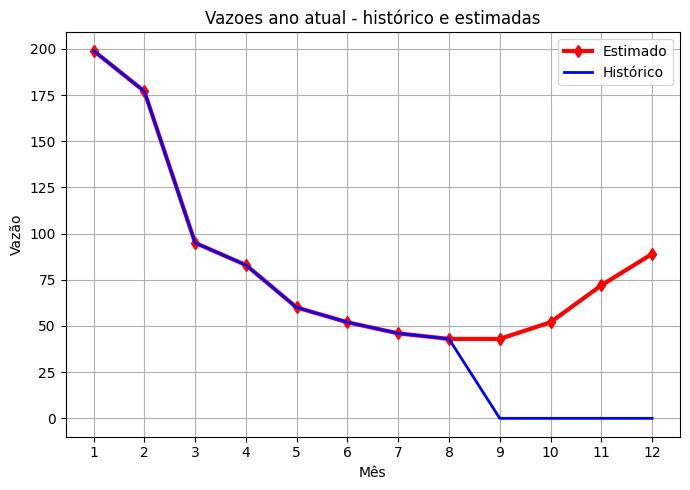

In [18]:
import numpy as np
Usina = PMOSET2023.confhd.get(nome_usina)
Num_hist = np.shape(Usina['vazoes'])[0]-2

import matplotlib.pyplot as plt

resposta=estimador_phi(nome_usina,12,mes_vazio)
print('Vazão Estimada: ',resposta[0])
print('Vazão Ano Atual: ',Usina['vazoes'][Num_hist+1])
x = np.arange(0,12,1)
plt.figure(figsize=(7,5))
plt.plot(x+1, resposta[0], marker='d',color='r',linewidth=3.0,label='Estimado')
plt.plot(x+1, Usina['vazoes'][Num_hist+1],color='b',linewidth=2.0,label='Histórico')
plt.title("Vazoes ano atual - histórico e estimadas")
plt.xlabel("Mês")
plt.ylabel("Vazão")
plt.xticks(x+1)
plt.grid()
plt.legend()
plt.tight_layout()

Vazão Estimada:  [199 177  95  83  60  52  46  43  40  52  71  94]
Vazão Ano Atual:  [199 177  95  83  60  52  46  43   0   0   0   0]


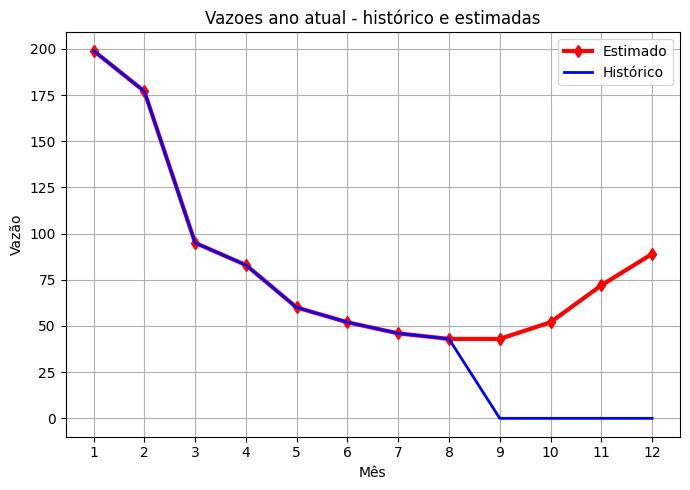

In [19]:
Usina = PMOSET2023.confhd.get(nome_usina)
Num_hist = np.shape(Usina['vazoes'])[0]-2

import matplotlib.pyplot as plt
resposta1=estimador_vazao(nome_usina,12,resposta[5],mes_vazio)
print('Vazão Estimada: ',resposta1[0])
print('Vazão Ano Atual: ',Usina['vazoes'][Num_hist+1])
x = np.arange(0,12,1)
plt.figure(figsize=(7,5))
plt.plot(x+1, resposta[0], marker='d',color='r',linewidth=3.0,label='Estimado')
plt.plot(x+1, Usina['vazoes'][Num_hist+1],color='b',linewidth=2.0,label='Histórico')
plt.title("Vazoes ano atual - histórico e estimadas")
plt.xlabel("Mês")
plt.ylabel("Vazão")
plt.xticks(x+1)
plt.grid()
plt.legend()
plt.tight_layout()